# Real Estate Price Prediction

### This is the course project for GeekBrains University

* Use sklearn.metrics.r2_score metrics for model quality assessment
* You need to get R2 > 0.6 on the Private Leaderboard
* All CSV files should contain header with column names and comma as delimiter. The indexes should be removed

Recommendations for working with the code:
1. Notebook must contain headers and comments
2. Use functions for repetitive operations
3. Add charts for describing the data (about 3-5)
4. Add only the best model, and don't include all possible models for solving the project
5. Notebook must work from beginning to end (from loading data to getting predictions)
6. The whole project must be in one notebook
7. When using statistics (mean, median, etc.) as features, it is better to calculate them on the train dataset, and use it on validation and test datasets withhout recalculation
8. The project should be evaluated in a reasonable time (no more than 10 minutes), so, do not include in the final version models with checking of a large number of combinations of parameters (GridSearch, etc).

### **Table of contents**
* [Loading data](#load)
* [1. EDA](#eda)
* [2. Processing outliers](#outlier)
* [3. Processing NaN values](#nan)
* [4. Feature generation](#feature)
* [5. Feature selection](#feature_selection)
* [6. Train and test split](#split)
* [7. Model building](#modeling)
* [8. Prediction on test dataset](#prediction)

### **Imports**

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
matplotlib.rcParams.update({'font.size': 14})

In [7]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### **Paths for train and test datasets**

In [8]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

## **Loading data** <a class='anchor' id='load'>

### **Dataset description**

* **Id** - flat identifier in dataset
* **DistrictId** - district identifier in dataset
* **Rooms** - rooms number
* **Square** - square of flat
* **LifeSquare** - living square of flat
* **KitchenSquare** - kitchen square of flat
* **Floor** - floor of flat
* **HouseFloor** - number of floors in house
* **HouseYear** - year where the house was built
* **Ecology_1, Ecology_2, Ecology_3** - ecology metrics of the area
* **Social_1, Social_2, Social_3** - social metrics of the area
* **Healthcare_1, Helthcare_2** - healthcare metrics of the area
* **Shops_1, Shops_2** - metrics related to the presence of shops, shopping centers
* **Price** - price of flat

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [10]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [12]:
print('Lines in train dataset:', train_df.shape[0])
print('Lines in test dataset:', test_df.shape[0])

Lines in train dataset: 10000
Lines in test dataset: 5000


In [13]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### **Types cast**

In [14]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [15]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## **1. EDA**  <a class='anchor' id='eda'>
We use EDA for:
- processing outliers
- filling NaN gaps
- finding ideas for new features

**Target variable**

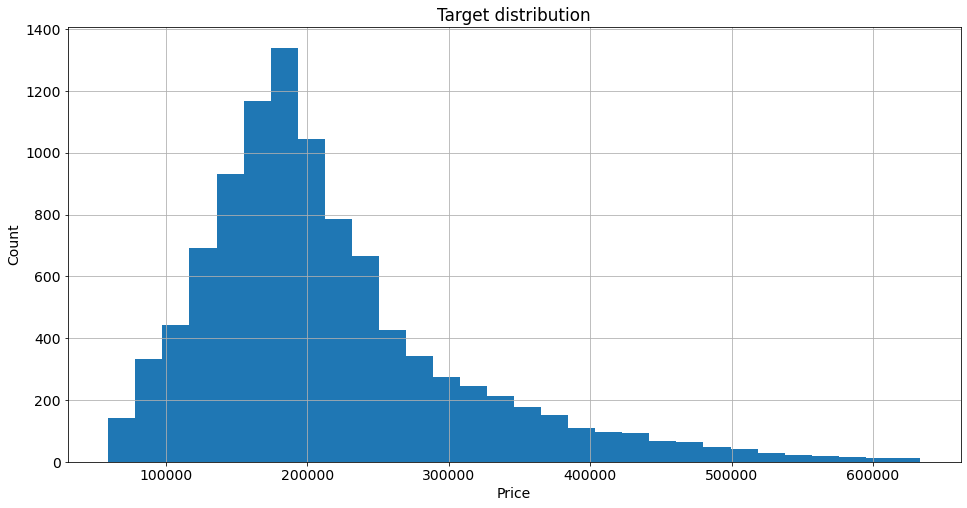

In [16]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Quantitative variables**

In [17]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Nominative variables**

In [18]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [19]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
205      1
207      1
196      1
199      1
117      1
Name: DistrictId, Length: 205, dtype: int64

In [20]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [21]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [22]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### **2. Processing outliers**  <a class='anchor' id='outlier'>
What we can do with outliers?
1. Drop these data on train
2. Replace them with medians, mean values, np.clip, etc
3. Create an additional feature by outlier data
4. Leave them alone :)

**Rooms**

In [23]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [24]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [25]:
rooms_median = train_df['Rooms'].median()
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = rooms_median

In [26]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**KitchenSquare** 

In [27]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [28]:
train_df['KitchenSquare'].quantile(.95), train_df['KitchenSquare'].quantile(.05)

(12.0, 0.0)

In [29]:
kitchen_square_median = train_df['KitchenSquare'].median()
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.95))
        
train_df.loc[condition, 'KitchenSquare'] = kitchen_square_median

train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = 5

In [30]:
train_df['KitchenSquare'].value_counts()

5.0     4391
8.0     1306
6.0     1294
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
Name: KitchenSquare, dtype: int64

**HouseFloor, Floor**

In [31]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [32]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [33]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [34]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [35]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [36]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [37]:
# If flat floor is higher than the max floor of house, this is the mistake in Floor or HouseFloor columns
# We can fix it in different ways, for example, fill Floor HouseFloor value
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']

In [38]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [39]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [40]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### **3. Processing NaN values**  <a class='anchor' id='nan'>

In [41]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [42]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,5.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,5.0
9,79.867477,75.085125,5.0


**LifeSquare**

In [43]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
condition.sum()

2113

In [44]:
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [45]:
condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
condition.sum()

0

**Healthcare_1**

In [46]:
train_df['Healthcare_1'].value_counts().sort_index()

0.0         1
30.0      348
32.0       12
35.0        2
46.0       49
         ... 
4087.0     45
4129.0     37
4508.0     46
4702.0     27
4849.0     15
Name: Healthcare_1, Length: 79, dtype: int64

In [47]:
# We have only one 0 value in Healthcare_1, so, probably we can fill NaNs with 0 too
train_df['Healthcare_1'].fillna(0, inplace=True)

In [48]:
class DataPreprocessing:
    """Class for train and test datasets preprocessing"""

    def __init__(self, kitchen_square_quantile=0.975, kitchen_square_min_threshold=3, balcony_square=3):
        """Preprocessing parameters"""
        self.medians = None
        self.kitchen_square_quantile = kitchen_square_quantile
        self.kitchen_square_min_threshold = kitchen_square_min_threshold
        self.balcony_square = balcony_square
    
    def fit(self, X):
        """Get statistics"""
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(self.kitchen_square_quantile)
    
    def transform(self, X):
        """Transform data"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < self.kitchen_square_min_threshold, 'KitchenSquare'] = self.kitchen_square_min_threshold
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        X['Healthcare_1'].fillna(0, inplace=True)
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - self.balcony_square
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### **4. Feature generation**  <a class='anchor' id='feature'>

**Dummies**

In [49]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

In [50]:
district_size = train_df['DistrictId'].value_counts().reset_index() \
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [51]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,0,0.0,0,0,1,305018.871089,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,1183.0,1,0,1,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,240.0,3,1,1,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,32.409907,5.0,10.0,22.0,1977,0.007122,...,0,0.0,0,1,1,168106.007630,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,2,0.0,0,6,1,343995.102962,0,0,0,89


In [52]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [53]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [54]:
med_price_by_district = train_df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,MedPriceByDistrict
0,0,165963.054142
1,1,183663.443595
2,10,217749.656911
3,100,234032.836228
4,101,184276.502773


In [55]:
med_price_by_district.shape

(205, 2)

In [56]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,1,851,1,146171.433190
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,78,0,183678.134031
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,652,1,183663.443595
3,2352,1,1.0,40.409907,32.409907,5.0,10.0,22.0,1977,0.007122,...,0,1,1,168106.007630,0,0,1,652,1,183663.443595
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,89,0,181706.718894


**MedPriceByFloorYear**

In [57]:
def floor_to_cat(X):
    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

def year_to_cat(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [58]:
bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1.0
1       2.0
2       0.0
3       3.0
4       4.0
       ... 
9995    0.0
9996    3.0
9997    0.0
9998    0.0
9999    2.0
Name: Floor, Length: 10000, dtype: float64

In [59]:
bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3.0, 5.0]
1         (5.0, 9.0]
2         (1.0, 3.0]
3        (9.0, 15.0]
4       (15.0, 42.0]
            ...     
9995      (1.0, 3.0]
9996     (9.0, 15.0]
9997      (1.0, 3.0]
9998      (1.0, 3.0]
9999      (5.0, 9.0]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[float64]): [(1.0, 3.0] < (3.0, 5.0] < (5.0, 9.0] < (9.0, 15.0] < (15.0, 42.0]]

In [60]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,1,305018.871089,0,0,1,851,1,146171.433190,5.0,1.0
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,177734.553407,0,0,0,78,0,183678.134031,2.0,2.0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1,282078.720850,0,0,0,652,1,183663.443595,3.0,0.0
3,2352,1,1.0,40.409907,32.409907,5.0,10.0,22.0,1977,0.007122,...,1,168106.007630,0,0,1,652,1,183663.443595,2.0,3.0
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,1,343995.102962,0,0,0,89,0,181706.718894,2.0,4.0


In [61]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,-1.0,2.0,287954.720682
1,0.0,-1.0,263299.720173
2,0.0,0.0,410299.956558
3,0.0,1.0,324303.812481
4,0.0,2.0,423580.477982


In [62]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,305018.871089,0,0,1,851,1,146171.433190,5.0,1.0,161744.506404
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,177734.553407,0,0,0,78,0,183678.134031,2.0,2.0,192213.977261
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,282078.720850,0,0,0,652,1,183663.443595,3.0,0.0,205210.068542
3,2352,1,1.0,40.409907,32.409907,5.0,10.0,22.0,1977,0.007122,...,168106.007630,0,0,1,652,1,183663.443595,2.0,3.0,184374.328532
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,343995.102962,0,0,0,89,0,181706.718894,2.0,4.0,175503.767602


In [63]:
class FeatureGenetator():
    """Class for feature generation for train and test datasets"""
    
    def __init__(self, large_district_threshold=100, med_price_by_district_grouping=[]):
        """Feature parameters"""
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
        self.large_district_threshold = large_district_threshold
        self.med_price_by_district_grouping = med_price_by_district_grouping
        
    def fit(self, X, y=None):
        """Get statistics"""
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(self.med_price_by_district_grouping, as_index=False).agg({'Price':'median'}) \
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
        
        ## Median price for square meter in each district
        if y is not None:
            self.district_price_per_square = df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'}) \
                                            .rename(columns={'Price':'DistrictPrice'})
            
            self.district_price_per_square_median = self.district_price_per_square['DistrictPrice'].median()
        
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
    
    def transform(self, X):
        """Transform data"""
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > self.large_district_threshold).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=self.med_price_by_district_grouping, how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        if self.district_price_per_square is not None:
            X = X.merge(self.district_price_per_square, on=['DistrictId'], how='left')
            X['DistrictPrice'].fillna(self.district_price_per_square_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        """floor_cat feature"""
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
    
    def year_to_cat(self, X):
        """year_cat feature"""
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### **5. Feature selection**  <a class='anchor' id='feature_selection'>

In [64]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [65]:
# Exclude Floor and Healthcare_1 columns for better predictions
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'HouseFloor', 'HouseYear', # 'Floor',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', # 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'DistrictPrice', 'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

### **6. Train and test split**  <a class='anchor' id='split'>

In [66]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [67]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)

In [69]:
preprocessor = DataPreprocessing(kitchen_square_quantile=0.95, kitchen_square_min_threshold=3,
                                 balcony_square=5)
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 23), (2000, 23), (5000, 23))

In [70]:
features_gen = FeatureGenetator(large_district_threshold=100, med_price_by_district_grouping=['DistrictId'])
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 31), (2000, 31), (5000, 31))

In [71]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [72]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### **7. Model building**  <a class='anchor' id='modeling'>

### **Learning**

All examples in this section should work. You can uncomment each model and check its evaluation.

**RandomForestRegressor**

In [73]:
# model = RandomForestRegressor(
#     random_state=21,
#     criterion='mse',
#     max_depth=9,
#     max_features=9,
#     n_estimators=200,
# )
# model.fit(X_train, y_train)

### 5.4 Gradient Boosting decision trees

In [74]:
y = np.array([10, 20, 30, 5, 10])

# Первое дерево
y_pred_1 = np.array([8, 25, 34, 10, 3])
error_1 = y - y_pred_1

error_1

array([ 2, -5, -4, -5,  7])

In [75]:
gb_pred = y_pred_1
r2(y, gb_pred)

0.7025

In [76]:
# Второе дерево: таргет = ошибки первого (error_1)
y_2 = error_1
y_pred_2 = np.array([1, -4, -2, -1, 3])

error_2 = y_2 - y_pred_2
error_2

array([ 1, -1, -2, -4,  4])

In [77]:
gb_pred = y_pred_1 + y_pred_2
r2(y, gb_pred)

0.905

In [78]:
# Третье дерево: таргет = ошибки второго (error_2)
y_3 = error_2
y_pred_3 = np.array([0, -1, -1, -1, 1])

error_2 = y_3 - y_pred_3
error_2

array([ 1,  0, -1, -3,  3])

In [79]:
gb_pred = y_pred_1 + y_pred_2 + y_pred_3
r2(y, gb_pred)

0.95

In [84]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.9
RMSE:	29291.8
MSE:	858009537.277


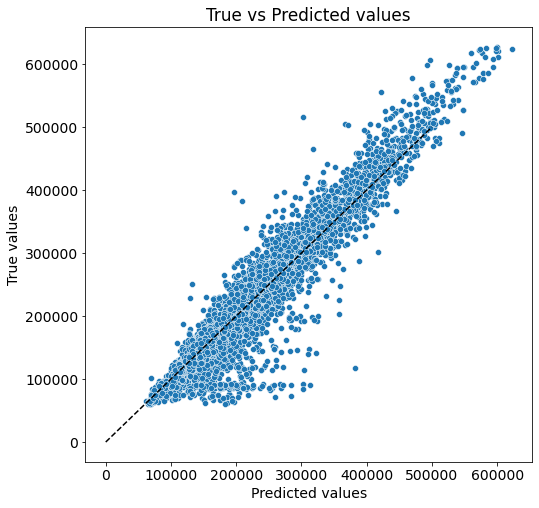

In [86]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [89]:
X = gb[feature_names]
y = gb[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

NameError: name 'gb' is not defined

In [87]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

NameError: name 'X_test' is not defined

**GridSearchCV with RandomForestRegressor**

In [72]:
# parameters = [{
#     'n_estimators': [100, 200, 400],
#     'max_features': np.arange(5, 10),
#     'max_depth': np.arange(4, 10),
# }]

# model = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=21, criterion='mse'),
#     param_grid=parameters,
#     scoring='r2',
#     cv=3,
# )
# model.fit(X_train, y_train)

# model.best_params_

**CatBoostRegressor**

In [73]:
model = CatBoostRegressor(
    learning_rate=0.03,
    depth=9,
    l2_leaf_reg=2,
    iterations=1000,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=21,
    silent=True,
)
model.fit(X_train, y_train)

**Grid search with CatBoostRegressor**

In [74]:
# model = CatBoostRegressor(
#     loss_function='RMSE',
#     eval_metric='RMSE',
# )

# grid = {
#     'learning_rate': [0.03, 0.1],
#     'depth': [4, 7, 10],
#     'n_estimators': [200, 600, 1000],
#     'l2_leaf_reg': [1, 5, 9]
# }

# grid_search_result = model.grid_search(
#     grid,
#     X=X_train,
#     y=y_train,
#     plot=True,
# )

In [75]:
# grid_search_result['params']

**XGBRegressor**

In [76]:
# model = XGBRegressor(n_estimators=400, max_depth=7, random_state=21)
# model.fit(X_train, y_train)

**LGBMRegressor**

In [77]:
# model = LGBMRegressor(
#     n_estimators=400,
#     random_state=21,
#     max_depth=15
# )
# model.fit(X_train, y_train)

**Model evaluation**

Train R2:	0.933
Test R2:	0.778


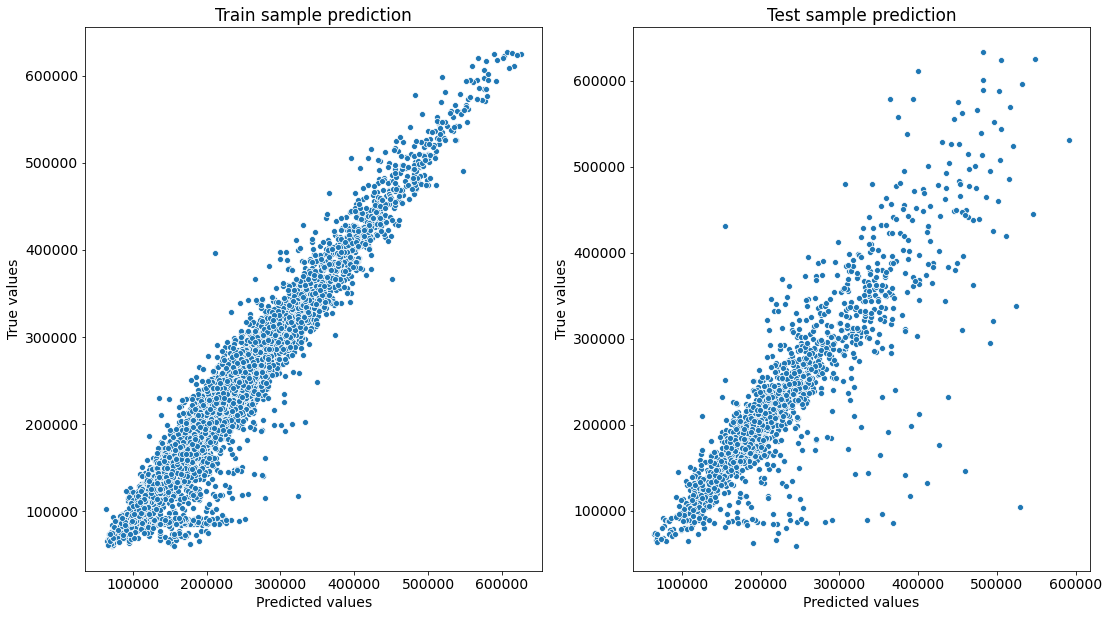

In [78]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### **Cross-validation**

In [79]:
cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75698084, 0.7239611 , 0.76063462])

In [80]:
cv_score.mean()

0.7471921864878203

**Feature importances**

In [81]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,26.427286
23,MedPriceByDistrict,9.072280
20,DistrictPrice,8.867921
24,MedPriceByFloorYear,6.233109
5,HouseYear,5.639281
11,Social_3,4.950455
3,KitchenSquare,4.685376
19,DistrictSize,4.526633
4,HouseFloor,4.297350
2,LifeSquare,4.192273


### **8. Prediction on test dataset** <a class='anchor' id='prediction'>

1. Make sure that evaluated data preprocesing and feature generation for test dataset too
2. Make sure that you didn't lose or mix indices in predicted data
3. Predictions should be evaluated for all rows from the test dataset

In [82]:
test_df.shape

(5000, 25)

In [83]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,DistrictPrice,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,9.0,1970,0.036122,1,1,24,...,0,0,0,0,86.0,206400.446460,0,0,206400.446460,186044.241187
1,1.0,42.493907,42.568133,10.0,17.0,2017,0.072158,1,1,2,...,0,0,0,0,193.0,162537.996292,0,1,162537.996292,179986.169695
2,2.0,59.463678,45.463678,9.0,19.0,1977,0.211401,1,1,9,...,0,0,0,1,691.0,146652.390009,0,1,146652.390009,174137.278013
3,3.0,49.646030,33.893825,6.0,2.0,1965,0.014073,1,1,2,...,0,0,0,0,444.0,113919.670183,0,1,113919.670183,182128.021554
4,1.0,53.837056,45.837056,3.0,17.0,1977,0.309479,1,1,35,...,0,0,0,1,81.0,212801.122972,0,0,212801.122972,190891.093552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,5.0,1962,0.069660,1,1,31,...,0,1,0,0,69.0,173315.200160,0,0,173315.200160,186044.241187
4996,3.0,93.698122,94.521465,10.0,27.0,2018,0.060753,1,1,15,...,0,0,0,0,29.0,317697.404029,0,0,317697.404029,195066.700021
4997,1.0,33.656723,19.003259,5.0,5.0,1966,0.038693,1,1,28,...,0,0,0,0,70.0,187448.635642,0,0,187448.635642,182128.021554
4998,1.0,38.635155,20.976257,9.0,14.0,1970,0.089040,1,1,33,...,0,0,0,0,46.0,217749.656911,0,0,217749.656911,190891.093552


In [84]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [85]:
predictions = model.predict(test_df)
predictions

array([164241.96435013, 119867.92609298, 145591.54121062, ...,
       148006.56047061, 195498.05636921, 261384.96947155])

In [86]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,164241.964350
1,5925,119867.926093
2,960,145591.541211
3,3848,99548.394162
4,746,206741.880306


In [87]:
submit.to_csv('submit.csv', index=False)